<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/groundino/zeroshotobjectdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

huggingface zero shot object detection
RefDocs: https://huggingface.co/docs/transformers/main/en/tasks/zero_shot_object_detection

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

In [ ]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [3]:
predictions = detector(
    image,
    candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner", "helmet"],
)

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

In [2]:
# text prompted
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

checkpoint = "google/owlvit-base-patch32"
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [ ]:
import requests

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
im

In [10]:
text_queries = ["hat", "book", "sunglasses", "camera", "bottle"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im


In [12]:
# Image guided object detection
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

In [9]:
from PIL import Image
image_target = Image.open("/content/zumen004.jpeg")
query_image = Image.open("/content/parts_1.jpg")

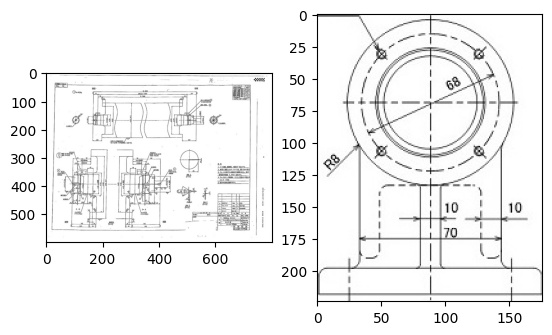

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [11]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

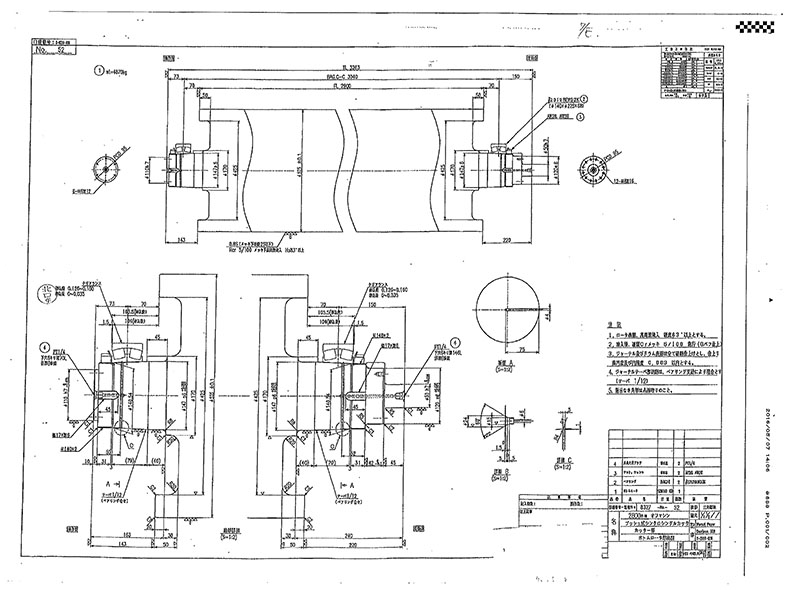

In [12]:
import torch
from PIL import ImageDraw

with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

image_target

Ground DINO zero shot object detection
https://github.com/IDEA-Research/GroundingDINO

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

In [2]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [4]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [3]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [6]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
/content/data


In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "dog-3.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "chair"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "dog-3.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "chair with man sitting on it"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

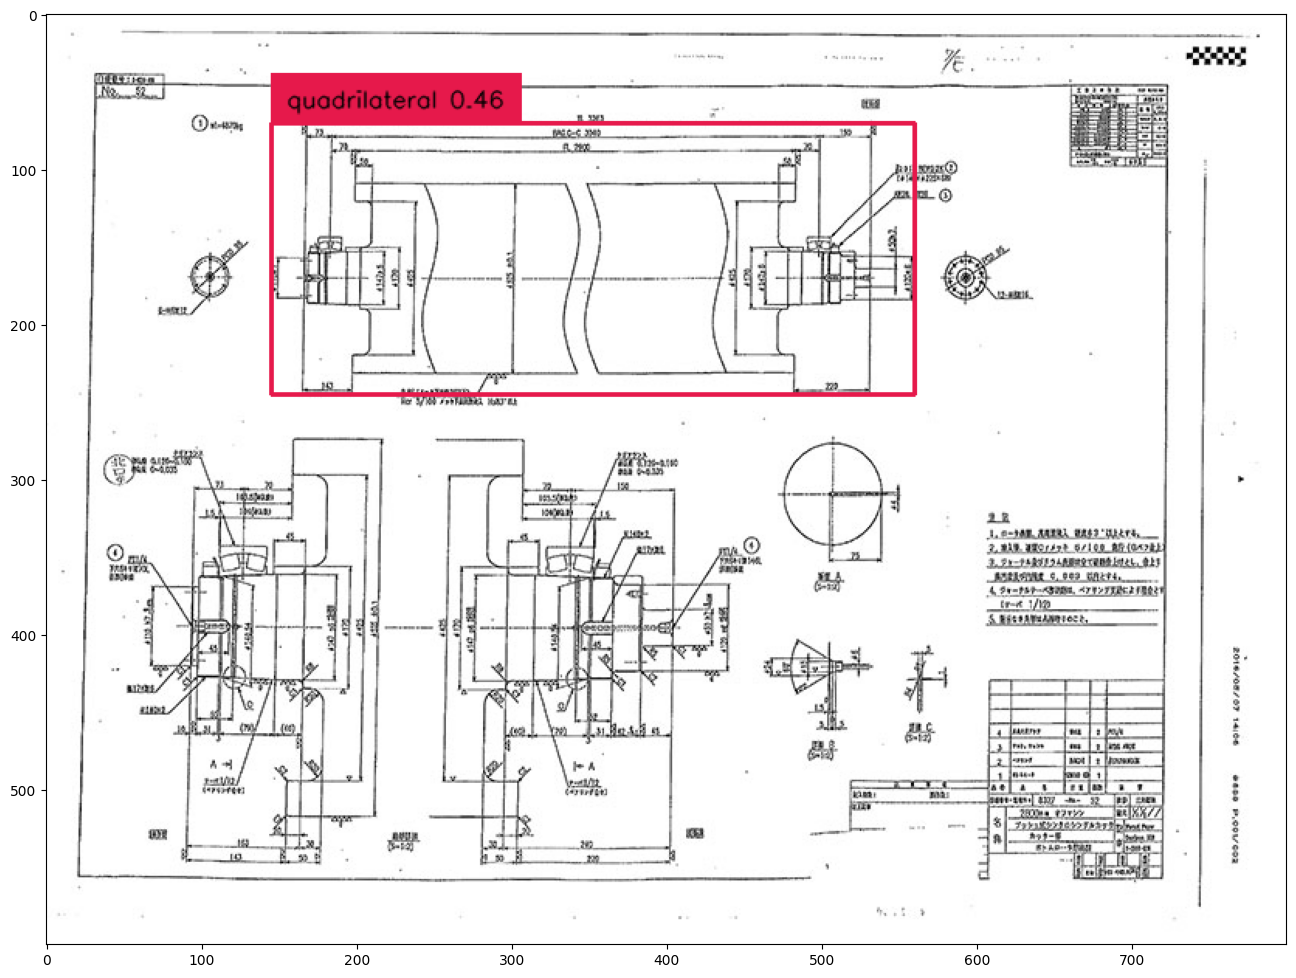

In [15]:
import os
import supervision as sv

IMAGE_NAME = "/content/zumen004.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "quadrilateral"  # rectangle, region, shape region, segment, fragment
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

In [11]:
import cv2
print(boxes)
cv2_image = cv2.imread(IMAGE_NAME)
ih, iw = cv2_image.shape[:2]
for idx, box in enumerate(boxes):
  xc, yc, w, h = box
  xc = int(xc * iw)
  yc = int(yc * ih)
  w = int(w * iw)
  h = int(h * ih)
  crop_img = cv2_image[yc - int(h / 2):yc + int(h / 2), xc - int(w / 2):xc + int(w / 2), :]
  cv2.imwrite(f"/content/parts_{idx}.jpg", crop_img)


tensor([[0.3268, 0.6727, 0.5683, 0.5971],
        [0.8196, 0.7134, 0.2412, 0.4300],
        [0.3335, 0.1803, 0.5646, 0.2765]])
